In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import scipy.io
from tqdm import tqdm
import json
import time
from scipy.interpolate import griddata

torch.manual_seed(1234)
np.random.seed(1234)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Fourier Neural Operator for Nonlinear Schrödinger Equation





In [ ]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 n
        self.modes2 = modes2  

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, 
                                                           self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, 
                                                           self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, 
                                                           self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, 
                                                           self.modes1, self.modes2, dtype=torch.cfloat))

    def compl_mul2d(self, inp, weights):
       
        return torch.einsum("bixy,ioxy->boxy", inp, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        
        x_ft = torch.fft.rfft2(x, dim=[-2, -1])

        
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1)//2 + 1, 
                           dtype=torch.cfloat, device=x.device)
        
        
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        
       
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)
        
        
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [10]:
class FourierLayer(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FourierLayer, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        
        self.conv = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w = nn.Conv2d(self.width, self.width, 1)
        
    def forward(self, x):
        x1 = self.conv(x)
        x2 = self.w(x)
        x = x1 + x2
        x = F.gelu(x)
        return x

In [ ]:
class NLS_FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width, layers=4, in_channels=3, out_channels=2):
        super(NLS_FNO2d, self).__init__()
        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.layers = layers
        
        
        self.fc0 = nn.Linear(in_channels, self.width)
        
        
        self.fourier_layers = nn.ModuleList([
            FourierLayer(self.modes1, self.modes2, self.width) for _ in range(self.layers)
        ])
        
        
        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, out_channels)
        
    def forward(self, x):
        
        x = self.fc0(x) 
        x = x.permute(0, 3, 1, 2)  
        
        for layer in self.fourier_layers:
            x = layer(x)
            
        
        x = x.permute(0, 2, 3, 1)  
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        
        return x

In [ ]:
def load_nls_data(data_path='NLS.mat', n_train=800, n_val=100, n_test=100):
    """
    Load and preprocess NLS data for FNO training
    """
    data = scipy.io.loadmat(data_path)
    
    t = data['tt'].flatten()[:, None]  # Time points
    x = data['x'].flatten()[:, None]   # Spatial points
    Exact = data['uu']  # Complex solution u + iv
    
    
    Exact_u = np.real(Exact)  # Real part
    Exact_v = np.imag(Exact)  # Imaginary part
    
   
    X, T = np.meshgrid(x.flatten(), t.flatten())
    
    
    x_grid = X.T  # Shape: (nx, nt)
    t_grid = T.T  # Shape: (nx, nt)
    
    
    u0 = Exact_u[:, 0:1]  # Shape: (nx, 1)
    v0 = Exact_v[:, 0:1]  # Shape: (nx, 1)
    
    
    u0_expanded = np.repeat(u0, t.shape[0], axis=1)  # Shape: (nx, nt)
    v0_expanded = np.repeat(v0, t.shape[0], axis=1)  # Shape: (nx, nt)
    
    
    input_data = np.stack([x_grid, t_grid, u0_expanded], axis=-1)  # Shape: (nx, nt, 3)
    
    
    output_data = np.stack([Exact_u, Exact_v], axis=-1)  # Shape: (nx, nt, 2)
    
    
    n_samples = n_train + n_val + n_test
    
    
    inputs = np.zeros((n_samples, *input_data.shape))
    outputs = np.zeros((n_samples, *output_data.shape))
    
    for i in range(n_samples):
        
        noise_scale = 0.01 * (i / n_samples)
        noise_u = noise_scale * np.random.randn(*u0_expanded.shape)
        noise_v = noise_scale * np.random.randn(*v0_expanded.shape)
        
        
        u0_pert = u0_expanded + noise_u
        
        inputs[i] = np.stack([x_grid, t_grid, u0_pert], axis=-1)
        
        
        outputs[i] = output_data
    
   
    train_input = inputs[:n_train]
    train_output = outputs[:n_train]
    
    val_input = inputs[n_train:n_train+n_val]
    val_output = outputs[n_train:n_train+n_val]
    
    test_input = inputs[n_train+n_val:]
    test_output = outputs[n_train+n_val:]
    
    return (torch.FloatTensor(train_input), torch.FloatTensor(train_output),
            torch.FloatTensor(val_input), torch.FloatTensor(val_output),
            torch.FloatTensor(test_input), torch.FloatTensor(test_output),
            x, t, X, T)

In [ ]:
def train_fno_nls(model, train_loader, val_loader, epochs=100, lr=1e-3):
    """
    Train the FNO model for NLS equation
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
    
    train_losses = []
    val_losses = []
    
    model.train()
    
    for epoch in tqdm(range(epochs), desc="Training FNO"):
        
        train_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = F.mse_loss(output, target)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.mse_loss(output, target).item()
        
        model.train()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        scheduler.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch:3d} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')
    
    return train_losses, val_losses

In [ ]:
def evaluate_model(model, test_loader, x, t):
    """
    Evaluate the trained model and compute errors
    """
    model.eval()
    
    predictions = []
    targets = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            predictions.append(output.cpu())
            targets.append(target)
    
    
    pred_tensor = torch.cat(predictions, dim=0)
    target_tensor = torch.cat(targets, dim=0)
    
   
    u_pred = pred_tensor[0, :, :, 0].numpy()
    v_pred = pred_tensor[0, :, :, 1].numpy()
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    
    u_true = target_tensor[0, :, :, 0].numpy()
    v_true = target_tensor[0, :, :, 1].numpy()
    h_true = np.sqrt(u_true**2 + v_true**2)
    
    
    error_u = np.linalg.norm(u_true - u_pred) / np.linalg.norm(u_true)
    error_v = np.linalg.norm(v_true - v_pred) / np.linalg.norm(v_true)
    error_h = np.linalg.norm(h_true - h_pred) / np.linalg.norm(h_true)
    
    print(f'FNO Relative L2 Error u: {error_u:.6e}')
    print(f'FNO Relative L2 Error v: {error_v:.6e}')
    print(f'FNO Relative L2 Error h: {error_h:.6e}')
    
    return u_pred, v_pred, h_pred, error_u, error_v, error_h

In [ ]:
def plot_comparison(u_true, v_true, h_true, u_pred, v_pred, h_pred, 
                   u_pinn=None, v_pinn=None, h_pinn=None, X=None, T=None, x=None, t=None):
    """
    Plot comparison between true solution, FNO prediction, and PINN prediction
    """
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
   
    im1 = axes[0,0].contourf(X, T, u_true.T, levels=50, cmap='RdYlBu')
    axes[0,0].set_title('True u(x,t)')
    axes[0,0].set_xlabel('x')
    axes[0,0].set_ylabel('t')
    plt.colorbar(im1, ax=axes[0,0])
    
    im2 = axes[1,0].contourf(X, T, v_true.T, levels=50, cmap='RdYlBu')
    axes[1,0].set_title('True v(x,t)')
    axes[1,0].set_xlabel('x')
    axes[1,0].set_ylabel('t')
    plt.colorbar(im2, ax=axes[1,0])
    
    im3 = axes[2,0].contourf(X, T, h_true.T, levels=50, cmap='viridis')
    axes[2,0].set_title('True |ψ(x,t)|')
    axes[2,0].set_xlabel('x')
    axes[2,0].set_ylabel('t')
    plt.colorbar(im3, ax=axes[2,0])
    
  
    im4 = axes[0,1].contourf(X, T, u_pred.T, levels=50, cmap='RdYlBu')
    axes[0,1].set_title('FNO u(x,t)')
    axes[0,1].set_xlabel('x')
    axes[0,1].set_ylabel('t')
    plt.colorbar(im4, ax=axes[0,1])
    
    im5 = axes[1,1].contourf(X, T, v_pred.T, levels=50, cmap='RdYlBu')
    axes[1,1].set_title('FNO v(x,t)')
    axes[1,1].set_xlabel('x')
    axes[1,1].set_ylabel('t')
    plt.colorbar(im5, ax=axes[1,1])
    
    im6 = axes[2,1].contourf(X, T, h_pred.T, levels=50, cmap='viridis')
    axes[2,1].set_title('FNO |ψ(x,t)|')
    axes[2,1].set_xlabel('x')
    axes[2,1].set_ylabel('t')
    plt.colorbar(im6, ax=axes[2,1])
    
    
    im7 = axes[0,2].contourf(X, T, np.abs(u_true - u_pred).T, levels=50, cmap='Reds')
    axes[0,2].set_title('FNO Error |u_true - u_pred|')
    axes[0,2].set_xlabel('x')
    axes[0,2].set_ylabel('t')
    plt.colorbar(im7, ax=axes[0,2])
    
    im8 = axes[1,2].contourf(X, T, np.abs(v_true - v_pred).T, levels=50, cmap='Reds')
    axes[1,2].set_title('FNO Error |v_true - v_pred|')
    axes[1,2].set_xlabel('x')
    axes[1,2].set_ylabel('t')
    plt.colorbar(im8, ax=axes[1,2])
    
    im9 = axes[2,2].contourf(X, T, np.abs(h_true - h_pred).T, levels=50, cmap='Reds')
    axes[2,2].set_title('FNO Error ||ψ|_true - |ψ|_pred|')
    axes[2,2].set_xlabel('x')
    axes[2,2].set_ylabel('t')
    plt.colorbar(im9, ax=axes[2,2])
    
    
    if x is not None and t is not None:
        t_idx = np.argmin(np.abs(t.flatten() - np.pi/4))
        
        axes[0,3].plot(x, u_true[:, t_idx], 'b-', label='True', linewidth=2)
        axes[0,3].plot(x, u_pred[:, t_idx], 'r--', label='FNO', linewidth=2)
        if u_pinn is not None:
            axes[0,3].plot(x, u_pinn[:, t_idx], 'g:', label='PINN', linewidth=2)
        axes[0,3].set_title(f'u(x, t={t.flatten()[t_idx]:.3f})')
        axes[0,3].set_xlabel('x')
        axes[0,3].legend()
        axes[0,3].grid(True)
        
        axes[1,3].plot(x, v_true[:, t_idx], 'b-', label='True', linewidth=2)
        axes[1,3].plot(x, v_pred[:, t_idx], 'r--', label='FNO', linewidth=2)
        if v_pinn is not None:
            axes[1,3].plot(x, v_pinn[:, t_idx], 'g:', label='PINN', linewidth=2)
        axes[1,3].set_title(f'v(x, t={t.flatten()[t_idx]:.3f})')
        axes[1,3].set_xlabel('x')
        axes[1,3].legend()
        axes[1,3].grid(True)
        
        axes[2,3].plot(x, h_true[:, t_idx], 'b-', label='True', linewidth=2)
        axes[2,3].plot(x, h_pred[:, t_idx], 'r--', label='FNO', linewidth=2)
        if h_pinn is not None:
            axes[2,3].plot(x, h_pinn[:, t_idx], 'g:', label='PINN', linewidth=2)
        axes[2,3].set_title(f'|ψ(x, t={t.flatten()[t_idx]:.3f})|')
        axes[2,3].set_xlabel('x')
        axes[2,3].legend()
        axes[2,3].grid(True)
    
    plt.tight_layout()
    plt.savefig('FNO_NLS_comparison.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:

config = {
    'modes1': 12,    # Number of Fourier modes in x direction
    'modes2': 12,    # Number of Fourier modes in t direction  
    'width': 64,     # Width of the network
    'layers': 4,     # Number of Fourier layers
    'epochs': 100,   # Number of training epochs
    'batch_size': 8, # Batch size
    'learning_rate': 1e-3,
    'n_train': 800,
    'n_val': 100,
    'n_test': 100
}

print("Loading NLS data...")
try:
    
    (train_input, train_output, val_input, val_output, 
     test_input, test_output, x, t, X, T) = load_nls_data(
        data_path='NLS.mat', 
        n_train=config['n_train'], 
        n_val=config['n_val'], 
        n_test=config['n_test']
    )
    
    print(f"Data shapes:")
    print(f"Train input: {train_input.shape}")
    print(f"Train output: {train_output.shape}")
    print(f"Validation input: {val_input.shape}")
    print(f"Test input: {test_input.shape}")
    
except FileNotFoundError:
    print("NLS.mat file not found. Please ensure the data file is in the current directory.")
    print("You can generate synthetic data or modify the path as needed.")

Loading NLS data...
Data shapes:
Train input: torch.Size([800, 256, 201, 3])
Train output: torch.Size([800, 256, 201, 2])
Validation input: torch.Size([100, 256, 201, 3])
Test input: torch.Size([100, 256, 201, 3])


In [17]:
# Create data loaders
train_dataset = torch.utils.data.TensorDataset(train_input, train_output)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)

val_dataset = torch.utils.data.TensorDataset(val_input, val_output)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)

test_dataset = torch.utils.data.TensorDataset(test_input, test_output)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

# Initialize model
model = NLS_FNO2d(
    modes1=config['modes1'], 
    modes2=config['modes2'], 
    width=config['width'], 
    layers=config['layers']
).to(device)

print(f"\nFNO Model Summary:")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

# Train the model
print("\nStarting FNO training...")
start_time = time.time()
train_losses, val_losses = train_fno_nls(
    model, train_loader, val_loader, 
    epochs=config['epochs'], 
    lr=config['learning_rate']
)
training_time = time.time() - start_time

print(f"Training completed in {training_time:.2f} seconds")


FNO Model Summary:
Total parameters: 9,462,658
Trainable parameters: 9,462,658

Starting FNO training...


Training FNO:   1%|          | 1/100 [00:10<17:55, 10.86s/it]

Epoch   0 | Train Loss: 0.050666 | Val Loss: 0.001043


Training FNO:  11%|█         | 11/100 [01:54<15:14, 10.28s/it]

Epoch  10 | Train Loss: 0.000289 | Val Loss: 0.000163


Training FNO:  21%|██        | 21/100 [03:35<13:14, 10.06s/it]

Epoch  20 | Train Loss: 0.000237 | Val Loss: 0.000055


Training FNO:  31%|███       | 31/100 [05:16<11:41, 10.16s/it]

Epoch  30 | Train Loss: 0.000288 | Val Loss: 0.000426


Training FNO:  41%|████      | 41/100 [07:00<10:16, 10.44s/it]

Epoch  40 | Train Loss: 0.000097 | Val Loss: 0.000028


Training FNO:  51%|█████     | 51/100 [08:44<08:30, 10.43s/it]

Epoch  50 | Train Loss: 0.000025 | Val Loss: 0.000024


Training FNO:  61%|██████    | 61/100 [10:27<06:44, 10.38s/it]

Epoch  60 | Train Loss: 0.000067 | Val Loss: 0.000023


Training FNO:  71%|███████   | 71/100 [12:10<04:57, 10.25s/it]

Epoch  70 | Train Loss: 0.000033 | Val Loss: 0.000022


Training FNO:  81%|████████  | 81/100 [13:52<03:14, 10.26s/it]

Epoch  80 | Train Loss: 0.000048 | Val Loss: 0.000040


Training FNO:  91%|█████████ | 91/100 [15:35<01:32, 10.25s/it]

Epoch  90 | Train Loss: 0.000061 | Val Loss: 0.000060


Training FNO: 100%|██████████| 100/100 [17:07<00:00, 10.27s/it]

Training completed in 1028.63 seconds



Evaluating FNO model...
FNO Relative L2 Error u: 7.027338e-03
FNO Relative L2 Error v: 7.833768e-03
FNO Relative L2 Error h: 5.342277e-03


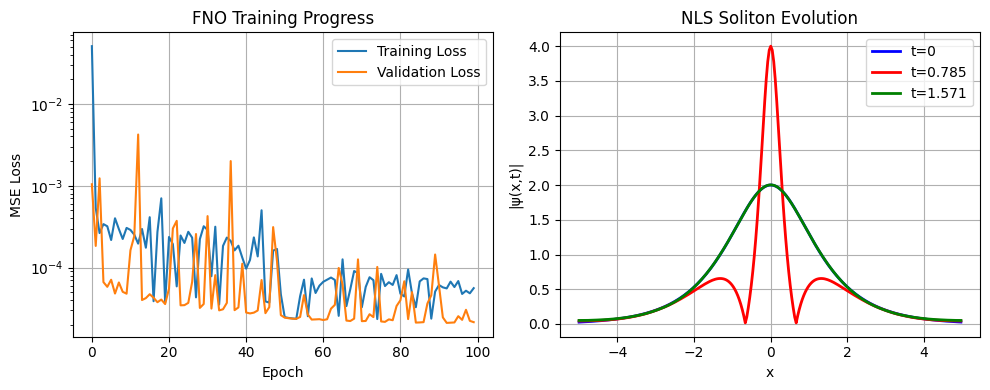

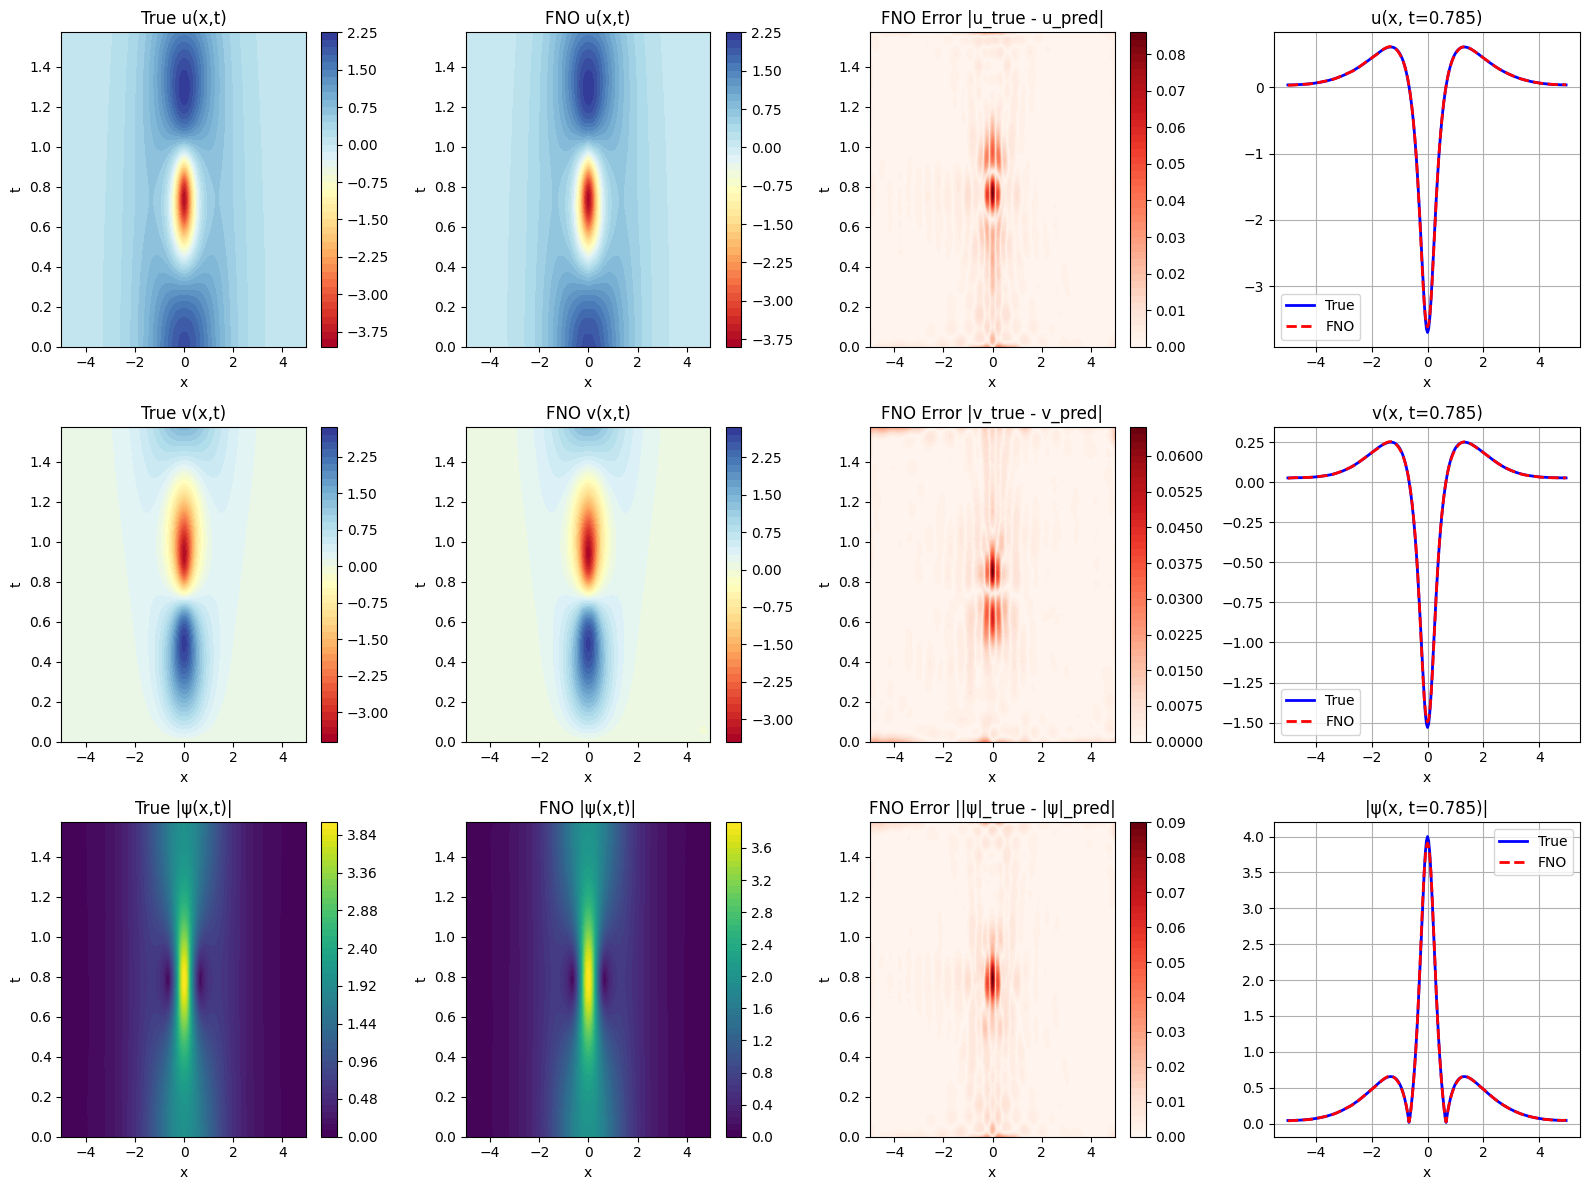

In [ ]:

print("\nEvaluating FNO model...")
u_pred, v_pred, h_pred, error_u, error_v, error_h = evaluate_model(model, test_loader, x, t)


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('FNO Training Progress')
plt.legend()
plt.grid(True)
plt.yscale('log')

data = scipy.io.loadmat('NLS.mat')
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

plt.subplot(1, 2, 2)
plt.plot(x, Exact_h[:, 0], 'b-', label='t=0', linewidth=2)
plt.plot(x, Exact_h[:, len(t)//2], 'r-', label=f't={t[len(t)//2, 0]:.3f}', linewidth=2)
plt.plot(x, Exact_h[:, -1], 'g-', label=f't={t[-1, 0]:.3f}', linewidth=2)
plt.xlabel('x')
plt.ylabel('|ψ(x,t)|')
plt.title('NLS Soliton Evolution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('FNO_training_progress.pdf', dpi=300)
plt.show()


plot_comparison(Exact_u, Exact_v, Exact_h, u_pred, v_pred, h_pred, X=X, T=T, x=x, t=t)


COMPARISON: FNO vs PINN

PINN Results (from TF1.ipynb):
  Relative L2 Error u: 1.012376e-02
  Relative L2 Error v: 1.534081e-02
  Relative L2 Error h: 3.012040e-03
  Training time: 369.10 seconds
  Network layers: [2, 40, 40, 40, 2]
  Training points: 200
  Collocation points: 20000

FNO Results:
  Relative L2 Error u: 7.027338e-03
  Relative L2 Error v: 7.833768e-03
  Relative L2 Error h: 5.342277e-03
  Training time: 1028.63 seconds
  Network parameters: 9,462,658
  Training samples: 800

Error Reduction (FNO vs PINN):
  u error: 30.6% improvement
  v error: 48.9% improvement
  h error: -77.4% increase
  Speed: 0.4x slower


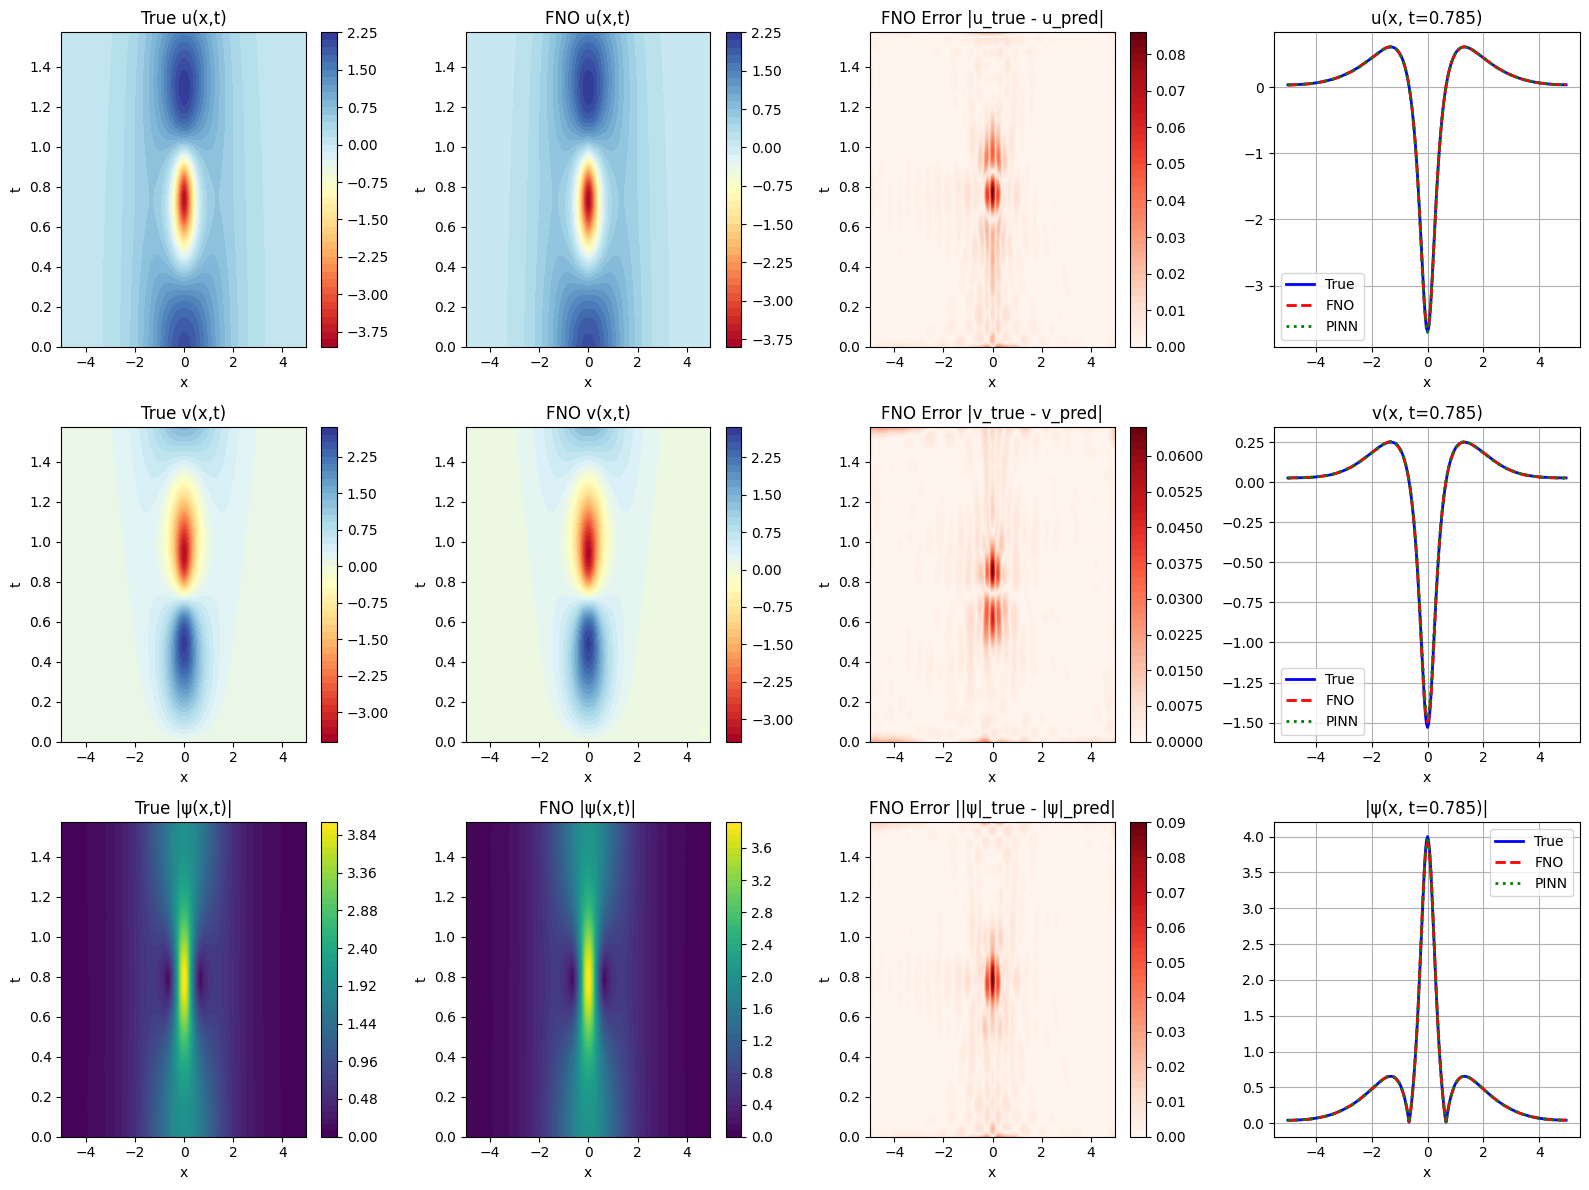

In [ ]:

try:
   
    pinn_data = np.load('PINN_results (1).npz')
    pinn_metadata = json.load(open('PINN_metadata.json', 'r'))
    
    U_pinn = pinn_data['U_pred']
    V_pinn = pinn_data['V_pred']
    H_pinn = pinn_data['H_pred']
    
    print("\n" + "="*60)
    print("COMPARISON: FNO vs PINN")
    print("="*60)
    
    print(f"\nPINN Results (from TF1.ipynb):")
    print(f"  Relative L2 Error u: {pinn_metadata['error_u']:.6e}")
    print(f"  Relative L2 Error v: {pinn_metadata['error_v']:.6e}")
    print(f"  Relative L2 Error h: {pinn_metadata['error_h']:.6e}")
    print(f"  Training time: {pinn_metadata['training_time_sec']:.2f} seconds")
    print(f"  Network layers: {pinn_metadata['layers']}")
    print(f"  Training points: {pinn_metadata['N0'] + pinn_metadata['Nb']}")
    print(f"  Collocation points: {pinn_metadata['Nf']}")
    
    print(f"\nFNO Results:")
    print(f"  Relative L2 Error u: {error_u:.6e}")
    print(f"  Relative L2 Error v: {error_v:.6e}")
    print(f"  Relative L2 Error h: {error_h:.6e}")
    print(f"  Training time: {training_time:.2f} seconds")
    print(f"  Network parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"  Training samples: {config['n_train']}")
    
   
    print(f"\nError Reduction (FNO vs PINN):")
    print(f"  u error: {(pinn_metadata['error_u'] - error_u)/pinn_metadata['error_u']*100:.1f}% {'improvement' if error_u < pinn_metadata['error_u'] else 'increase'}")
    print(f"  v error: {(pinn_metadata['error_v'] - error_v)/pinn_metadata['error_v']*100:.1f}% {'improvement' if error_v < pinn_metadata['error_v'] else 'increase'}")
    print(f"  h error: {(pinn_metadata['error_h'] - error_h)/pinn_metadata['error_h']*100:.1f}% {'improvement' if error_h < pinn_metadata['error_h'] else 'increase'}")
    
  
    speedup = pinn_metadata['training_time_sec'] / training_time
    print(f"  Speed: {speedup:.1f}x {'faster' if speedup > 1 else 'slower'}")
    
    plot_comparison(Exact_u, Exact_v, Exact_h, u_pred, v_pred, h_pred,
                   u_pinn=U_pinn.T, v_pinn=V_pinn.T, h_pinn=H_pinn.T, X=X, T=T, x=x, t=t)
    
except FileNotFoundError:
    print("\nPINN results not found. Run TF1.ipynb first to generate comparison data.")
    print("FNO model trained successfully with the following results:")
    print(f"  Relative L2 Error u: {error_u:.6e}")
    print(f"  Relative L2 Error v: {error_v:.6e}")
    print(f"  Relative L2 Error h: {error_h:.6e}")

In [20]:
# Save FNO results
print("\nSaving FNO results...")

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'training_time': training_time
}, 'FNO_NLS_model.pth')

# Save predictions
np.savez_compressed('FNO_NLS_results.npz',
    x=x.flatten(),
    t=t.flatten(), 
    X=X,
    T=T,
    u_pred=u_pred,
    v_pred=v_pred,
    h_pred=h_pred,
    u_true=Exact_u,
    v_true=Exact_v,
    h_true=Exact_h,
    error_u=error_u,
    error_v=error_v,
    error_h=error_h
)

# Save metadata
fno_metadata = {
    'model_type': 'FNO',
    'modes1': config['modes1'],
    'modes2': config['modes2'],
    'width': config['width'],
    'layers': config['layers'],
    'total_parameters': sum(p.numel() for p in model.parameters()),
    'n_train': config['n_train'],
    'n_val': config['n_val'], 
    'n_test': config['n_test'],
    'epochs': config['epochs'],
    'batch_size': config['batch_size'],
    'learning_rate': config['learning_rate'],
    'error_u': float(error_u),
    'error_v': float(error_v),
    'error_h': float(error_h),
    'training_time_sec': float(training_time),
    'final_train_loss': float(train_losses[-1]),
    'final_val_loss': float(val_losses[-1])
}

with open('FNO_NLS_metadata.json', 'w') as f:
    json.dump(fno_metadata, f, indent=4)

print("\n" + "="*60)
print("FNO FOR NONLINEAR SCHRÖDINGER EQUATION - SUMMARY")
print("="*60)
print(f"Model successfully trained and evaluated!")
print(f"Results saved to:")
print(f"  - FNO_NLS_model.pth (model weights)")
print(f"  - FNO_NLS_results.npz (predictions)")
print(f"  - FNO_NLS_metadata.json (configuration)")
print(f"  - FNO_NLS_comparison.pdf (plots)")
print("\nRun TF1.ipynb to generate PINN results for detailed comparison.")


Saving FNO results...

FNO FOR NONLINEAR SCHRÖDINGER EQUATION - SUMMARY
Model successfully trained and evaluated!
Results saved to:
  - FNO_NLS_model.pth (model weights)
  - FNO_NLS_results.npz (predictions)
  - FNO_NLS_metadata.json (configuration)
  - FNO_NLS_comparison.pdf (plots)

Run TF1.ipynb to generate PINN results for detailed comparison.
